# Decision Trees

## ACM SIGKDD Austin Chapter

### Carlos Santillan


Sample Decision Trees with Scikit-Learn


### Import

Load the required components. 

Note that this notebook requires the installation of graphviz http://www.graphviz.org/ 
and pydotplus https://pypi.python.org/pypi/pydotplus in order to see a visualization of the Decision tree 

In [2]:
from __future__ import print_function

import os
from IPython.display import Image  
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import  cross_val_score
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline


## Exploration

Load the data

https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes





In [3]:
raw_dir = os.path.join(os.getcwd(), os.pardir, "data/raw/")
diabetesdf = pd.read_csv(raw_dir+"pimadiabetes.csv",index_col=0)

print("* diabetesdf.head()", diabetesdf.head(10), sep="\n", end="\n\n")
print("* diabetesdf.tail()", diabetesdf.tail(10), sep="\n", end="\n\n")

* diabetesdf.head()
    noPreg  plasma  diastolic  triceps  insulin   bmi  pedigree  age  class  \
id                                                                            
1        6     148         72       35        0  33.6     0.627   50      1   
2        1      85         66       29        0  26.6     0.351   31      0   
3        8     183         64        0        0  23.3     0.672   32      1   
4        1      89         66       23       94  28.1     0.167   21      0   
5        0     137         40       35      168  43.1     2.288   33      1   
6        5     116         74        0        0  25.6     0.201   30      0   
7        3      78         50       32       88  31.0     0.248   26      1   
8       10     115          0        0        0  35.3     0.134   29      0   
9        2     197         70       45      543  30.5     0.158   53      1   
10       8     125         96        0        0   0.0     0.232   54      1   

        diag  
id            
1

In [4]:
print("* Class types:", diabetesdf["diag"].unique(), sep="\n")

* Class types:
['Diabetes' 'Healthy']


In [5]:
features = list(diabetesdf.columns[:8])
print("* features:", features, sep="\n")

* features:
['noPreg', 'plasma', 'diastolic', 'triceps', 'insulin', 'bmi', 'pedigree', 'age']


In [6]:
y = diabetesdf["class"]
X = diabetesdf[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print ("* Training sample size : ", len(X_train))
print ("* Validation sample size : ", len(X_test))

* Training sample size :  614
* Validation sample size :  154


Building the Decision Tree. 
For full usage of Decision Tree Classifier refer to scikit-learn api http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


Tunable parameters:

* criterion : 'gini' or 'entropy' default 'gini'
* min_samples_split : The minimum number of samples required to split an internal node.
* random_state : seed to use for random number generator
* max_depth : The maximum depth of the tree


In [7]:
dt = tree.DecisionTreeClassifier(criterion='gini',min_samples_split=5, random_state=1024)
dt.fit(X_train, y_train)
#dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1024, splitter='best')

## Calculate the scores 

Score against the training set

In [8]:
def printScores(amodel, xtrain,ytrain,xtest,ytest):
    tscores = amodel.score( xtrain, ytrain)
    vscores = amodel.score( xtest, ytest)
    print ("Training score is %f" % tscores)
    print ("Validation score is %f" % vscores)
    print ("Model depth is %i" % amodel.tree_.max_depth )


printScores(dt,X_train,y_train, X_test,y_test)

Training score is 0.975570
Validation score is 0.740260
Model depth is 12


## Visualize Decision Tree

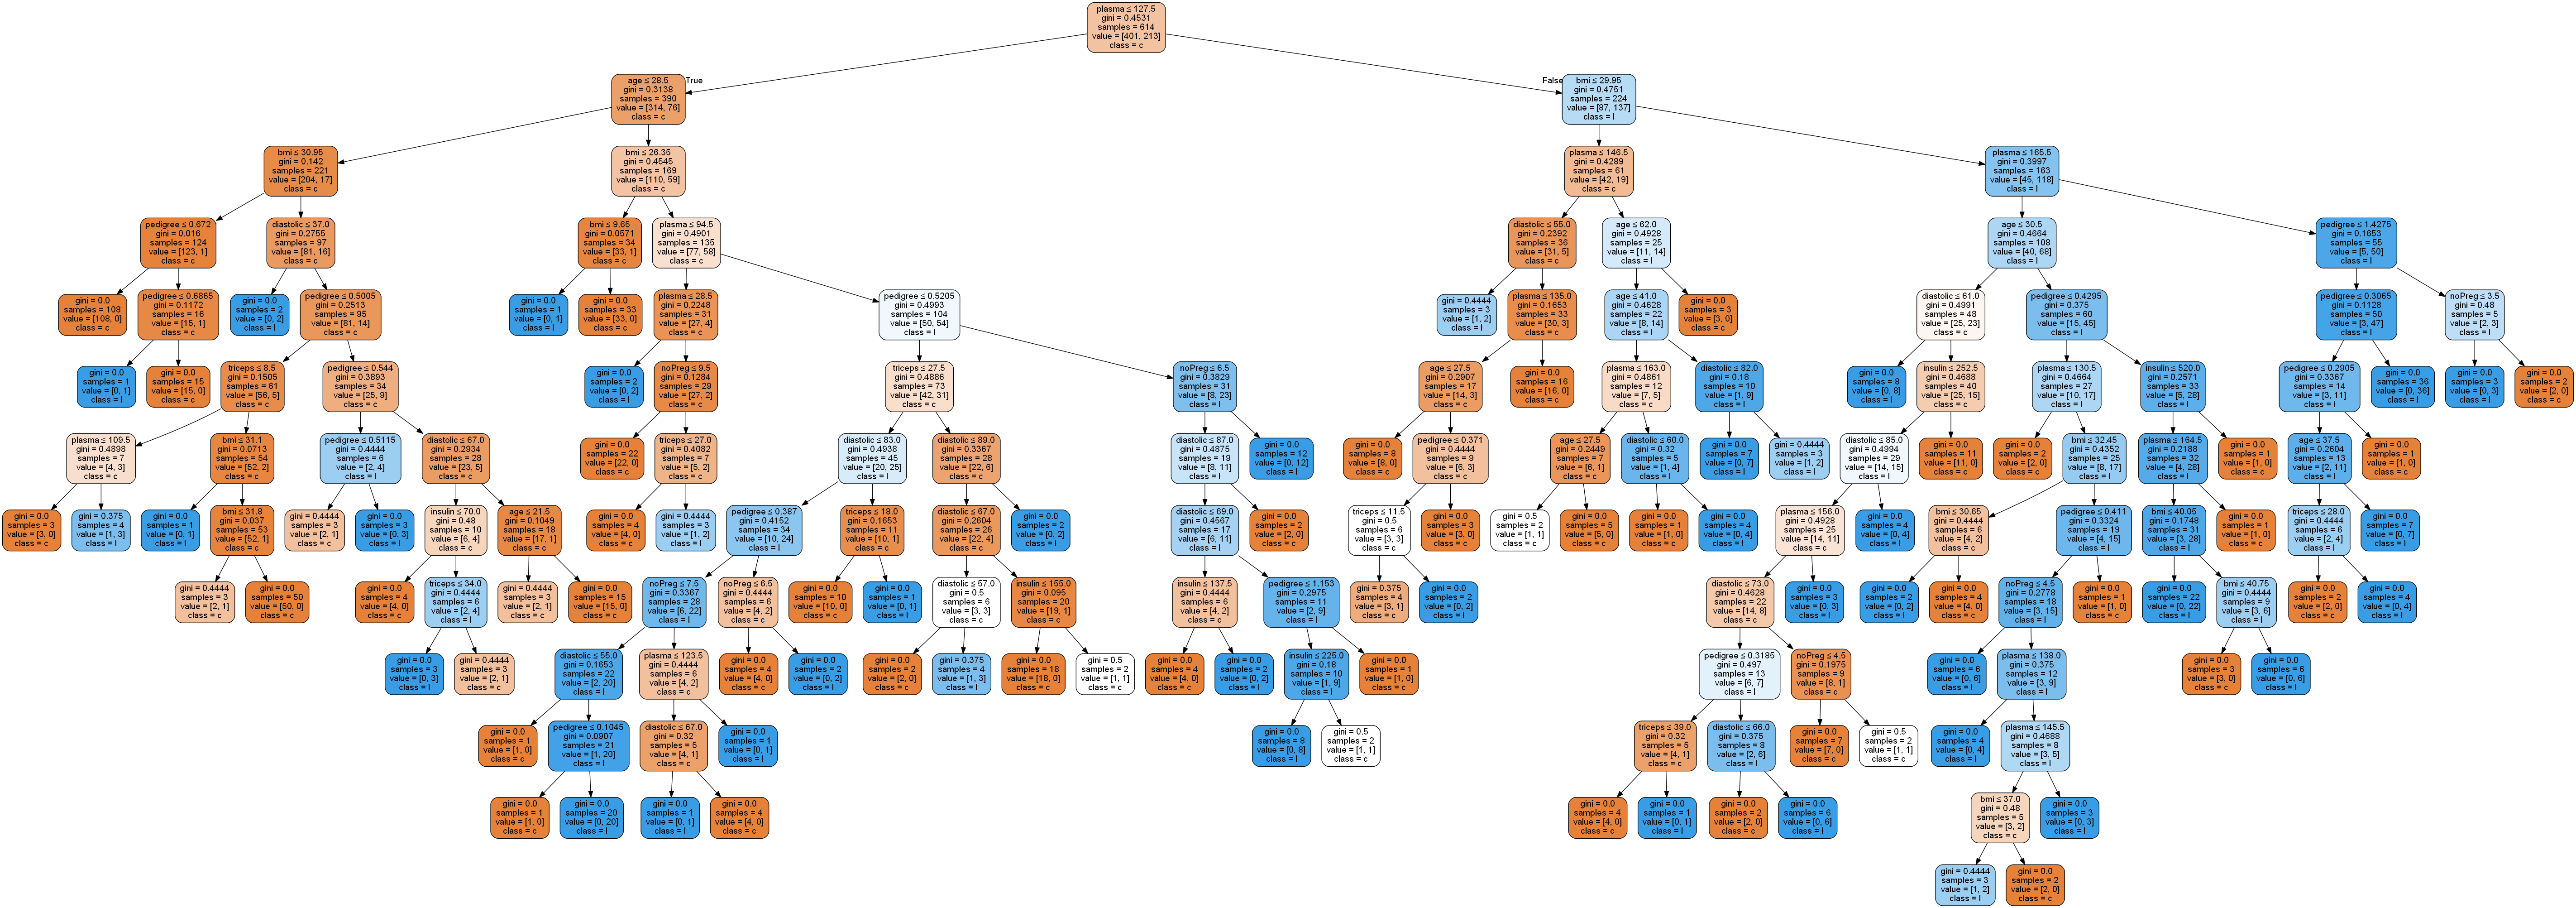

In [9]:
dot_data = StringIO()  
tree.export_graphviz(dt, out_file=dot_data,  
                     feature_names=features,  
                     class_names='class',  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Feature Importance


The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance





In [15]:
def listFeatureImportance(amodel, features):
    ### Extract feature importance
    ## based from 
    ## http://stackoverflow.com/questions/34239355/feature-importance-extraction-of-decision-trees-scikit-learn

    importances = amodel.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print('Feature Ranking:')

    for f in range(len(features)):
        if importances[indices[f]] > 0:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
            print ("\tfeature name: ", features[indices[f]])
            
#listFeatureImportance(dt, features)
            

## Crossvalidation and parameter tuning

Using GridSearchCV to test model performance under different parameters combinations



In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV

param_grid = { 'criterion':['gini','entropy'], 'max_depth': range(1,15) ,  
              'min_samples_split': range(1,15),'min_samples_leaf':range(1,10)}

Gridtree = GridSearchCV(DecisionTreeClassifier(),  param_grid,n_jobs=2,cv=3)
Gridtree.fit(X_train, y_train)
tree_preds = Gridtree.predict_proba(X_test)[:, 1]

tree_performance = roc_auc_score(y_test, tree_preds)

print("Best Classifier : %s (Best Score %0.2f)" % (Gridtree.best_estimator_   , Gridtree.best_score_ ))
print("ROC AUC  : (%0.2f)" % (tree_performance ))


bc = Gridtree.best_estimator_



Best Classifier : DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=4,
            min_samples_split=12, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best') (Best Score 0.77)
ROC AUC  : (0.81)


In [17]:
bc.fit(X_train, y_train)
printScores(bc,X_train,y_train, X_test,y_test)

Training score is 0.833876
Validation score is 0.785714
Model depth is 5


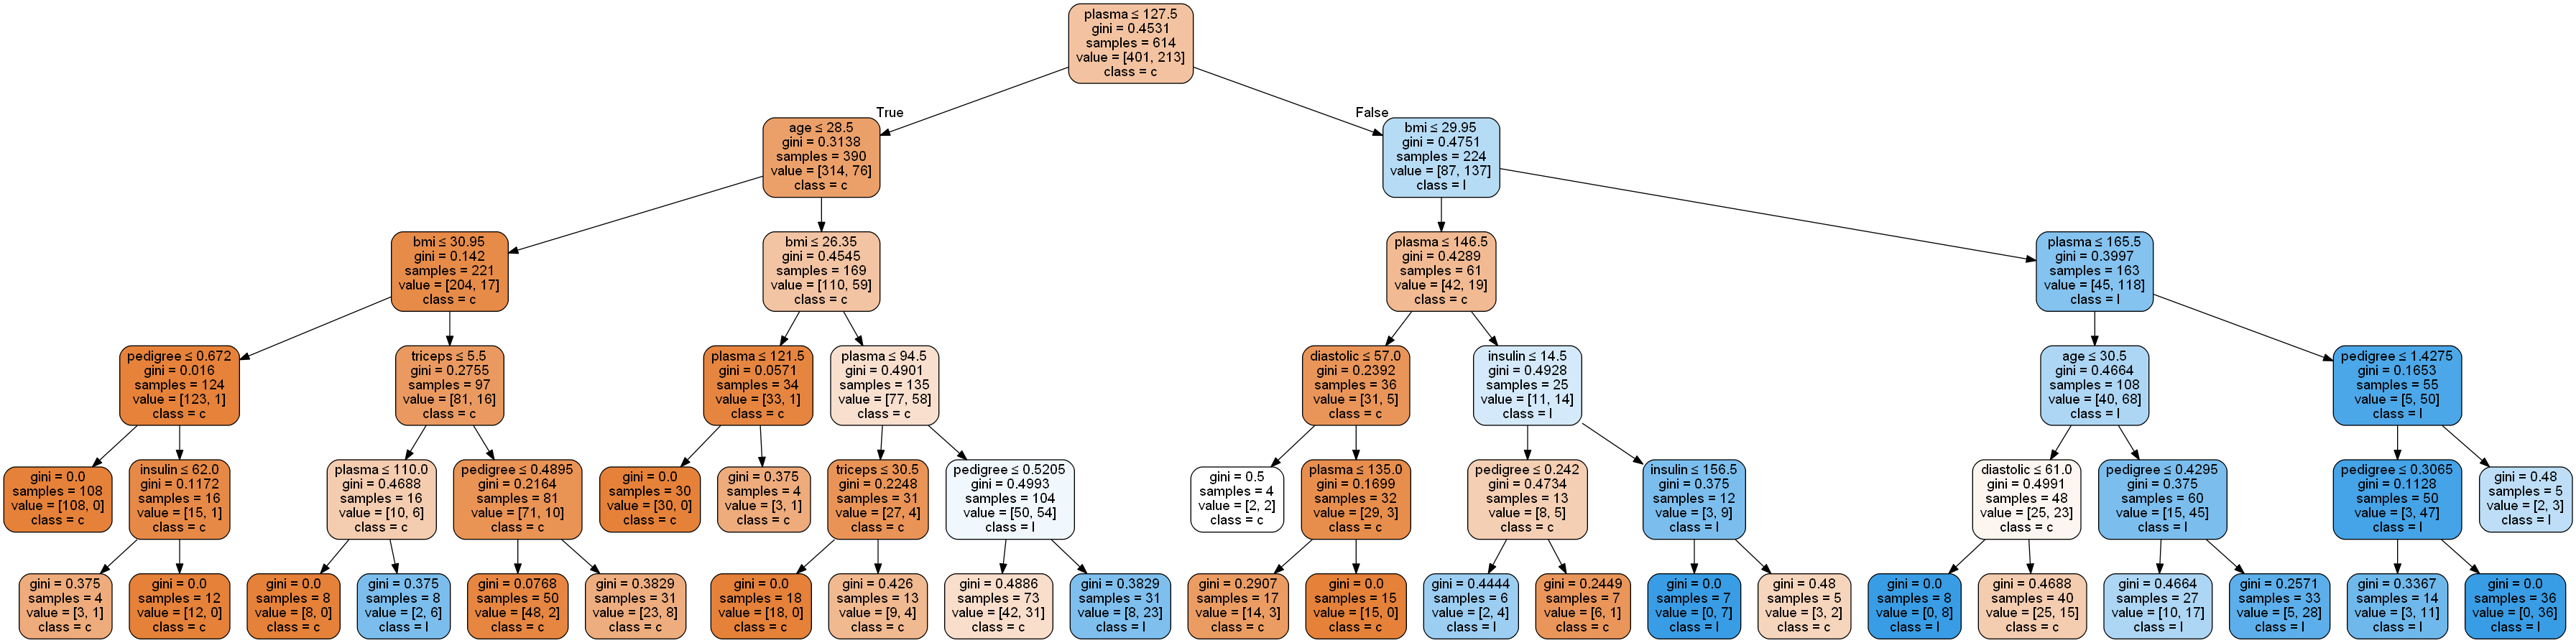

In [13]:
dot_data = StringIO()  
tree.export_graphviz(bc, out_file=dot_data,  
                     feature_names=features,  
                     class_names='class',  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [14]:
print ("Original Model")
listFeatureImportance(dt, features)
printScores(dt,X_train,y_train, X_test,y_test)
print ("\n\nBest Model")
listFeatureImportance(bc, features)
printScores(bc,X_train,y_train, X_test,y_test)

Original Model
Feature Ranking:
1. feature 1 (0.325877)
	feature name:  plasma
2. feature 5 (0.162099)
	feature name:  bmi
3. feature 2 (0.152661)
	feature name:  diastolic
4. feature 6 (0.099658)
	feature name:  pedigree
5. feature 7 (0.099277)
	feature name:  age
6. feature 3 (0.063162)
	feature name:  triceps
7. feature 0 (0.049970)
	feature name:  noPreg
8. feature 4 (0.047296)
	feature name:  insulin
Training score is 0.975570
Validation score is 0.740260
Model depth is 12


Best Model
Feature Ranking:
1. feature 1 (0.511714)
	feature name:  plasma
2. feature 5 (0.185497)
	feature name:  bmi
3. feature 7 (0.126799)
	feature name:  age
4. feature 6 (0.080425)
	feature name:  pedigree
5. feature 2 (0.044703)
	feature name:  diastolic
6. feature 4 (0.029007)
	feature name:  insulin
7. feature 3 (0.021855)
	feature name:  triceps
Training score is 0.833876
Validation score is 0.785714
Model depth is 5
